# World2Vec   
   
Word(단어) to Vector(벡터) 로 나타내는 것   
   
가장 널리 사용되고 있는 임베딩 방법 중 하나   
- 임베딩(Embedding) : 사람이 사용하는 자연어를 기계가 이해할 수 있는 숫자인 벡터로 나타내는 과정  
벡터가 아닌 것을 벡터로 표현하는 것   
   
특정 단어 양 옆에 있는 두 단어의 관계를 활용하기에, 분포 가설을 잘 반영하고 있음   
- 분포가설 : 비슷한 위치에서 등장하는 단어들은 비슷한 의미들을 가진다.   
단어 분포를 기준으로 단어의 벡터 표현이 결정됨    
분산표현(Distributed Representation)이라고도 부름   
   
자연어 처리뿐만 아니라, 추천 시스템에서도 자주 사용함

In [2]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 25.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [16]:
# 네이버 영화 리뷰 데이터를 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7ed02da2f340>)

In [17]:
# 데이터를 데이터프레임 형식으로 불러오기 (상위 5개만 확인차 출력)
train_data = pd.read_table('ratings.txt')
train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [18]:
# 총 리뷰 갯수 확인
print('리뷰 갯수 : ', len(train_data))

리뷰 갯수 :  200000


In [19]:
# 총 20만개의 데이터 중 결측값이 존재할 수도 있다.
# any() : 하나라도 있으면 True 리턴 (OR 연산)
# all() : 모두 True 여야 True를 반환하겠다 (AND 연산)
print('결측값 여부 : ', train_data.isnull().values.any())

결측값 여부 :  True


In [20]:
# 결측값이 존재하는 행 제거
train_data = train_data.dropna(how = 'any')
print('결측값 제거 후 리뷰 갯수 : ', len(train_data))
print(train_data.isnull().values.any())

결측값 제거 후 리뷰 갯수 :  199992
False


In [21]:
# 총 199,992개의 리뷰가 존재...
#정규 표현식으로 한글이 아닌 리뷰만 출력
import re
for i in train_data['document']:
    if not re.search(r'[\uac00-\ud7af]', i):
      print(i)

# 정규 표현식으로 한글이 아닌 리뷰는 해당 내용을 출력 후 제거
# 공백문자(띄어쓰기) \s 까지 추가해서 띄어쓰기에 대한 내용은 처리 안하도록
# regex = True 옵션 써야 정규표현식 적용됨
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9\s]","",regex=True)
train_data.head()

ㅎㅎㅎㅎㅎㅎㅎㅎ
ㅇㅋㅇㅋ
goodgoodgoodgoodgoodgoodgood
Very interesting
Killing time yong good
GOOD~
♥♥
ㅎㅎ
1236547890
good good good
supercalifragilisticexpialidocious~
10
ㄹㄹ
Good
not bad
ㅋ
best movie ever
*♥♥♥♥♥
Carpe diem!!
.... very good
ㅇ
3.14
Good
Good! Good! Good!
‥
O
good
I love this series so much!! very familiar name 'SAMSUN'
GOOD
sihoo,your best! Come on!
Very good!
God is good. always.
it might be you
it's good man.
ㅎ
good good good
zxcvfgrwdgyj7
.
best of best 10
the best of the best
Two thumbs up! T.T
ㅇㅇ
Two thumbs up!!
It was very good!!!
...
Tanakaりえ様.ガンダム見たいですね.ウングワンヨルシムヒします.
same rules apply!
And so it is,
g
Good
♥
I wish you love
oh it such a perfect day
EAT MY SHIT!
that's what i see!!
Good!
dsadsdasdasdasd
.
ㅠㅠ
....ㅠㅡㅜ
ㅆ
best of the bests
.
Very Very Well Made ~
Don't cry for me ~~~~~~~~~~~~ argentina
.
brilliant
..
La Merr~~~~
I IOVE IT...
ㅋㅋㅋ
not bad
fdddddfffd
Good Morning Baltmore~
will crying
night fever!
無言
All you need is love.
gg
Battle....
.
Asdfgnvtrw
Justice is blind

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [22]:
# 불용어 제거

# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

okt = Okt()

tokenized_data = []
for sentence in train_data['document']:
  # 동사는 원형으로 바꿔서 표현
  tokenized_sentence = okt.morphs(sentence, stem = True)

  # 불용어 제거
  stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
  tokenized_data.append(stopwords_removed_sentence)

리뷰의 최대 길이 :  72
리뷰의 평균 길이 :  10.85944437777511


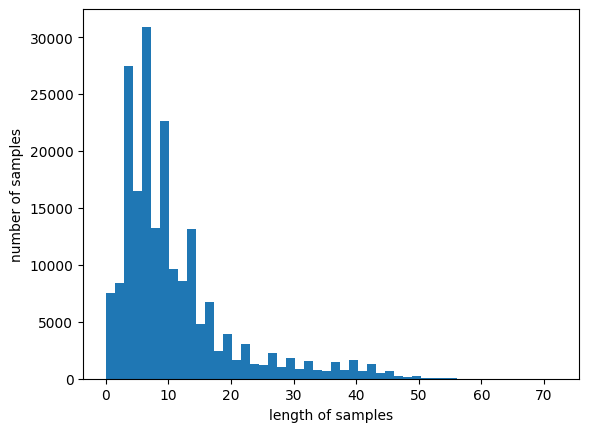

In [24]:
# 토큰화가 된 상태에서 각 리뷰의 길이 분포를 확인

print('리뷰의 최대 길이 : ',max(len(review) for review in tokenized_data))

print('리뷰의 평균 길이 : ' , sum(map(len, tokenized_data)) / len(tokenized_data))

plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [25]:
# Word2Vec 모델에 토큰화 된 데이터를 학습시키기

model = Word2Vec(sentences = tokenized_data, vector_size= 100,
                 window = 5, min_count=5, workers=4, sg=0)

# 하이퍼 파라미터 : 머신러닝의 모델에 대해 사용자가 직접 설정 할 수 있는 옵션
# 옵션을 어떻게 잡느냐에 따라 따라 성능 차이가 꽤 남

# vector_size : 임베딩 된 벡터의 차원을 나타냄
# window : context window의 크기 - 타겟 토큰에서 유효한 범위?
# min_count : 단어 최소 빈도수, 5 미만은 학습하지 않음
# workers : 학습을 위한 프로세스의 수
# sg : 학습 알고리즘 지정 / 0 : Continuous Bag of Word(CBOW), 1 : Skip-gram
# CBOW : 주변 단어들의 정보를 통해 중심 단어를 예측하는 방법
# Skip-gram : 하나의 단어에서 여러 단어들을 예측하는 방법

In [26]:
# Word2Vec 임베딩 행렬의 크기 확인
model.wv.vectors.shape

(16841, 100)

In [29]:
# 총 16,842개의 단어가 존재, 각 단어는 100차원으로 구성되어 있음
# '최민식' 과 유사한 단어 찾기
# model.wv.most_similar() 함수 활용 - 해당 단어와 유사하다고 판단한 단어 추출 가능
print(model.wv.most_similar('최민식'))

for i in model.wv.most_similar('최민식'):
  print('유사도 : ' + i[0] + ". {:.2f}".format(i[1]*100 )+ '%')

[('한석규', 0.8410952687263489), ('안성기', 0.828288733959198), ('박중훈', 0.822932243347168), ('스탭', 0.8095067739486694), ('최민수', 0.8070521354675293), ('신인', 0.8063184022903442), ('최강희', 0.8042511940002441), ('유다인', 0.803530216217041), ('채민서', 0.7993134260177612), ('이정재', 0.7985201478004456)]
유사도 : 한석규. 84.11%
유사도 : 안성기. 82.83%
유사도 : 박중훈. 82.29%
유사도 : 스탭. 80.95%
유사도 : 최민수. 80.71%
유사도 : 신인. 80.63%
유사도 : 최강희. 80.43%
유사도 : 유다인. 80.35%
유사도 : 채민서. 79.93%
유사도 : 이정재. 79.85%


In [30]:
# '히어로' 와 유사한 단어들 뽑기
print(model.wv.most_similar('히어로'))

# positive, negative 파라미터를 통해서 아래와 같은 예시도 구현 가능
# 무협 + 정통 - 로코 ( 무협, 정통이면서 로코가 아닌)
print(model.wv.most_similar(positive = ['무협','정통'], negative = ['로코']))

[('슬래셔', 0.8511428833007812), ('무협', 0.8222863078117371), ('느와르', 0.8182975649833679), ('호러', 0.8107857704162598), ('물의', 0.8095609545707703), ('정통', 0.7958456873893738), ('홍콩', 0.7916680574417114), ('블록버스터', 0.7886847853660583), ('무비', 0.7864549160003662), ('물', 0.7798585295677185)]
[('헐리우드', 0.7555681467056274), ('진수', 0.7521050572395325), ('단순', 0.7390472888946533), ('헐리웃', 0.7277429699897766), ('홍콩', 0.7272597551345825), ('블록버스터', 0.7180486917495728), ('싸구려', 0.7111682891845703), ('슬래셔', 0.7096906304359436), ('첩보', 0.7083368897438049), ('느와르', 0.7078043222427368)]
